In [1]:
import os
import pandas as pd
import numpy as np

# Sklearn libraries for encoding, regression, and scaling
from IPython.display import display, Latex
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Stats api for linear regression
import statsmodels.api as sm

# Stats api for varaince inflation factor to screen the features
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# Metric for evaluating the model
from sklearn.metrics import mean_squared_error, r2_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_style('whitegrid')
sns.set_palette('icefire')

# Surpress warnings
import warnings
warnings.filterwarnings('ignore')

### Read data

In [2]:
df = pd.read_csv('../inputs/day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Split dataset into train and test

In [3]:
train, test = train_test_split(df, random_state = 3407, train_size = 0.8)
train['kind'], test['kind'] = 'train', 'test'
df = pd.concat([train, test])
df.sample(2)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,kind
164,165,14-06-2018,2,0,6,0,2,1,1,24.770847,29.57730,50.7083,18.041961,727,4164,4891,test
115,116,26-04-2018,2,0,4,0,2,1,1,25.898347,29.70415,72.9167,21.875500,678,3722,4400,train


### Data preprocessing

In [4]:
# remove casual and registered columns from the dataset because they are linked to the total customer count (target)
# We could use them in target encoding but it seems out of scope for the project.
remove_features = ['casual', 'registered']
df.drop(remove_features, axis = 1, inplace = True)

Encoding

In [5]:
# catergorical features with multiple labels
multi_label_features = ['season', 'mnth', 'weekday', 'weathersit']

# categorical features with binary labels
binary_features      = ['yr', 'holiday', 'workingday']

# numerical features
num_features         = ['temp', 'atemp', 'hum', 'windspeed']

# target
target               = 'cnt'

In [6]:
## feature engineering

# new features
df['week_num']      = pd.to_datetime(df['dteday']).dt.weekofyear
df['day_num']       = pd.to_datetime(df['dteday']).dt.day
#df['vapor_pressue'] = df.apply(lambda r: (0.01 * r['hum']) * (6.112 *(0.01 * r['hum'])**(17.67 * r['temp'] / (r['temp'] + 243.5))), axis = 1)

# Transformation
df['log_atemp']     = df['atemp'].apply(np.log10)
df['log_temp']      = df['temp'].apply(np.log10)

# interation between features
df['atemp-temp']    = df['atemp'] - df['temp']
df['atemp_div_temp']= df['log_atemp'] - df['log_temp']

num_features += ['log_atemp', 'log_temp', 'week_num', 'day_num']
iteration_features = ['atemp-temp', 'atemp_div_temp']

In [7]:
## label encoding
encoded_df = pd.concat([pd.get_dummies(df[f], prefix = f, drop_first = True) for f in multi_label_features], axis = 1)

## scaling on the entire dataset
# Alteratively, I can scale on the train dataset and use it to transform on both train and test dataset separately.
# This approach is not necessary. 
num_scaler = StandardScaler()
df[num_features + iteration_features] = num_scaler.fit_transform(df[num_features + iteration_features])

tgt_scaler = StandardScaler()
df[target] = tgt_scaler.fit_transform(df[target].values.reshape(-1, 1))

# scale multilabel categorical features to preserve ordinal nature of the dataset
ord_scaler = MinMaxScaler()
df[multi_label_features] = ord_scaler.fit_transform(df[multi_label_features])

df.sample(2)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,hum,windspeed,cnt,kind,week_num,day_num,log_atemp,log_temp,atemp-temp,atemp_div_temp
592,593,16-08-2019,0.666667,1,0.636364,0,0.666667,1,0.0,1.221953,...,-0.762483,-0.628488,1.600774,train,0.436625,0.031769,0.981820,1.057636,-0.132630,-0.966356
698,699,30-11-2019,1.000000,1,0.909091,0,0.833333,1,0.0,-1.078120,...,0.154143,-1.703698,0.599577,train,1.433508,1.623357,-0.776736,-0.990924,0.464081,1.808388


In [8]:
## combine endoded features
df.drop(columns = ['dteday', 'instant'], inplace = True)
df = pd.concat([df, encoded_df], axis = 1)
print(df.shape)
df.head()

(730, 41)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
700,1.000000,1,1.000000,0,0.000000,0,0.5,-0.809397,-0.707933,1.375341,...,0,1,0,0,0,0,0,0,1,0
651,1.000000,1,0.818182,0,0.000000,0,0.0,0.142515,0.206745,0.089720,...,0,0,0,0,0,0,0,0,0,0
708,1.000000,1,1.000000,0,0.166667,1,0.5,-0.326612,-0.239121,2.089905,...,0,1,1,0,0,0,0,0,1,0
110,0.333333,0,0.272727,0,0.666667,1,0.0,-0.199080,-0.126674,-1.550262,...,0,0,0,0,0,1,0,0,0,0
648,1.000000,1,0.818182,0,0.666667,1,0.0,-0.331165,-0.266181,-1.154911,...,0,0,0,0,0,1,0,0,0,0


### Modeling

Baseline

In [9]:
train = df[df['kind'] == 'train'].drop(columns = 'kind')
test  = df[df['kind'] == 'test'].drop(columns = 'kind')

train.shape, test.shape

((584, 40), (146, 40))

Model with stats api

In [10]:
def prediction(model, test, drop_columns):

    X_test = test.drop(columns = [target] + drop_columns)
    y_test = test[target]
    
    X_test = sm.add_constant(X_test)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred = y_pred)
    
    return r2, mse

def automate(train, test, trial, drop_columns = [], print_summary = False):
    
    done = False
    drop_feature = ''
    
    X = train.drop(columns = [target] + drop_columns).astype(float)
    y = train[target].astype(float)

    # add intercept
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
        
    # screen on p-value
    p_values = model.pvalues
    p_values = p_values.sort_values(ascending = False)
    
    if p_values[0] > 0.05:
        drop_feature = p_values.index[0]
    
    ### PREDICTION ON TEST SET
    test_r2, _ = prediction(model, test, drop_columns)
    
    ### REPORTING
    print(f'Trial # {trial}')
    if drop_feature != '':
        if not print_summary:
            print(f'Features dropped : {drop_feature} becasue p-value ({p_values[0]:.6f}) is > 0.05')
    else:
        if not print_summary:
            print('No features dropped')
        done = True
    
    if not print_summary: 
        print(f'r-squared       - train : {model.rsquared:.6f}')
        print(f'r-squared       - test  : {test_r2:.6f}\n')
    
    if print_summary:
        print(model.summary())
    
    return done, drop_feature

In [11]:
def automate_on_vif(train, drop_columns = [], threshold = 5, print_vif_table = False):
    
    done = False
    drop_feature = ''
    X = train.drop(columns = [target] + drop_columns)
    
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    
    # calculating VIF for each feature
    vif_data["VIF"] = [vif(np.array(X.values, dtype = np.float32), i) for i in range(len(X.columns))]
    
    top = vif_data.sort_values(by = 'VIF', ascending = False).head(1)
    top_vif = top['VIF'].values[0]
    if  top_vif > threshold:
        drop_feature = top['feature'].values[0]
        if not print_vif_table:
            print(f'Features dropped : {drop_feature} becasue vif ({top_vif:.1f}) is > {threshold}')
    else:
        if not print_vif_table:
            print('No features dropped')
        done = True
        
    if print_vif_table:
        display(vif_data.sort_values(by = 'VIF', ascending = False))
    
    return done, drop_feature

In [12]:
trial = 1
drop_columns = []
while True:
    done, drop_feature = automate(train, test, trial = trial, drop_columns = drop_columns, print_summary = False)
    trial += 1
    if not done:
        drop_columns.append(drop_feature)
    else:
        _ = automate(train, test, trial = trial, drop_columns = drop_columns, print_summary = True)
        break

Trial # 1
Features dropped : mnth_7 becasue p-value (0.992819) is > 0.05
r-squared       - train : 0.848287
r-squared       - test  : 0.871365

Trial # 2
Features dropped : atemp becasue p-value (0.989914) is > 0.05
r-squared       - train : 0.848287
r-squared       - test  : 0.871365

Trial # 3
Features dropped : atemp_div_temp becasue p-value (0.988368) is > 0.05
r-squared       - train : 0.848287
r-squared       - test  : 0.871365

Trial # 4
Features dropped : temp becasue p-value (0.966519) is > 0.05
r-squared       - train : 0.848287
r-squared       - test  : 0.871365

Trial # 5
Features dropped : weathersit_2 becasue p-value (0.908445) is > 0.05
r-squared       - train : 0.848286
r-squared       - test  : 0.871412

Trial # 6
Features dropped : weekday_2 becasue p-value (0.833675) is > 0.05
r-squared       - train : 0.848286
r-squared       - test  : 0.871412

Trial # 7
Features dropped : mnth_2 becasue p-value (0.827891) is > 0.05
r-squared       - train : 0.848286
r-squared     

In [13]:
while True:
    done, drop_feature = automate_on_vif(train, threshold = 5, drop_columns = drop_columns)
    trial += 1
    
    if not done:
        if drop_feature != '':
            drop_columns.append(drop_feature)
            _ = automate(train, test, trial = trial, drop_columns = drop_columns, print_summary = False)
    else:
        _ = automate(train, test, trial = trial, drop_columns = drop_columns, print_summary = True)
        _ = automate_on_vif(train, drop_columns = drop_columns,  threshold = 10, print_vif_table = True)
        break

Features dropped : season becasue vif (333599972397814.5) is > 5
Trial # 23
No features dropped
r-squared       - train : 0.845078
r-squared       - test  : 0.872986

No features dropped
Trial # 24
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     171.2
Date:                Thu, 14 Sep 2023   Prob (F-statistic):          4.81e-215
Time:                        00:02:07   Log-Likelihood:                -279.41
No. Observations:                 584   AIC:                             596.8
Df Residuals:                     565   BIC:                             679.9
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
            

,feature,VIF
7,season_3,4.548383
1,workingday,3.919099
2,weathersit,3.265644
8,season_4,3.198257
6,season_2,3.095361
5,log_temp,2.594838
3,hum,2.074576
10,mnth_5,1.938781
0,yr,1.909901
14,mnth_11,1.887543


Final model

In [14]:
print('List of features removed from the modeling excerise are:')
print(', '.join(drop_columns))

List of features removed from the modeling excerise are:
mnth_7, atemp, atemp_div_temp, temp, weathersit_2, weekday_2, mnth_2, weekday_5, weekday_4, atemp-temp, mnth_10, weekday, week_num, day_num, log_atemp, weekday_3, mnth_4, weekday_1, mnth, holiday, season


In [15]:
# List of features show influence on the target variable - customers using the Bike rental services
features = [c for c in df.columns if c not in drop_columns + [target, 'kind']]

# prepare train / test datasets
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# create model / fit
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train).fit()

# predict
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_test)

# Evaluate scores
train_r2    = r2_score(y_true = y_train, y_pred = y_train_preds)
test_r2     = r2_score(y_true = y_test, y_pred = y_test_preds)

print(f'R-square of prediction on train dataset: {train_r2:.6f}')
print(f'R-square of prediction on test dataset : {test_r2:.6f}')

R-square of prediction on train dataset: 0.845078
R-square of prediction on test dataset : 0.872986


Residuals

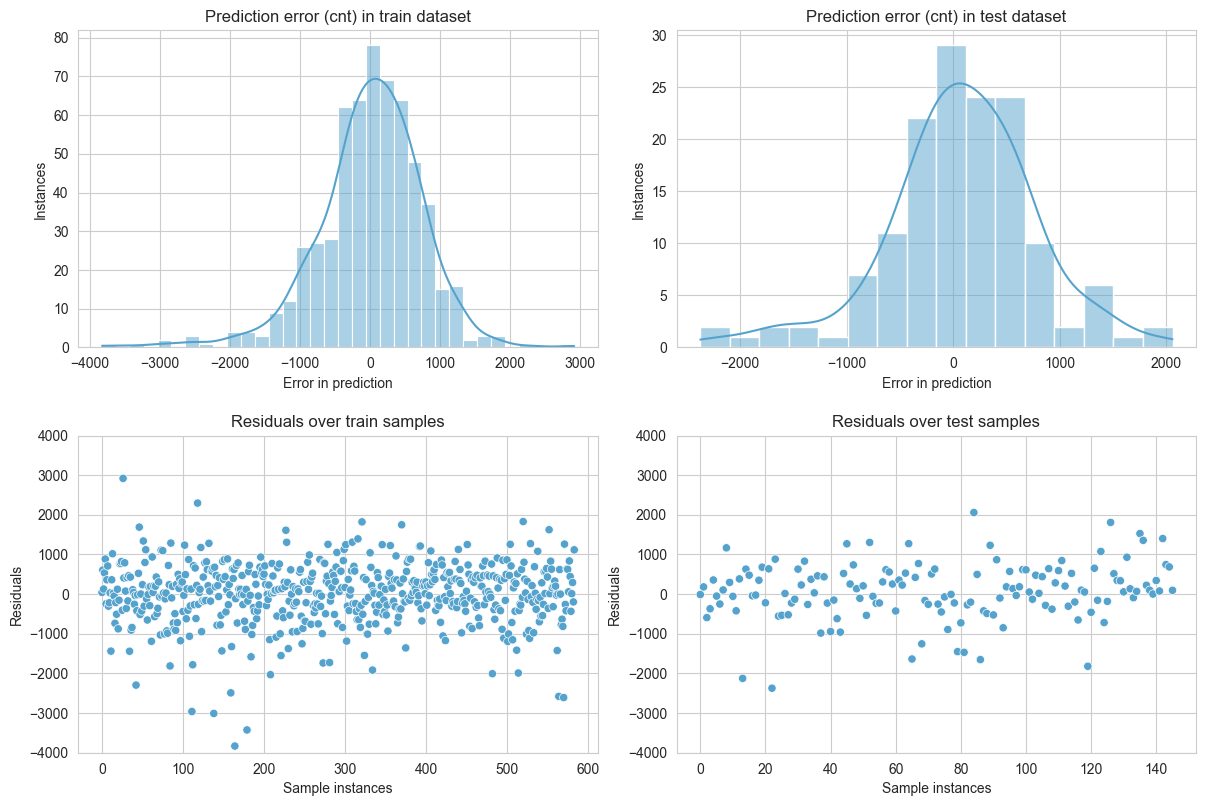

In [16]:
## Transform the target (cnt) back to original scale

# Train
act_y_train      = tgt_scaler.inverse_transform(np.array(y_train).reshape(-1, 1))
act_y_train_pred = tgt_scaler.inverse_transform(np.array(y_train_preds).reshape(-1, 1))
train_residuals = act_y_train - act_y_train_pred

# Test
act_y_test      = tgt_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
act_y_test_pred = tgt_scaler.inverse_transform(np.array(y_test_preds).reshape(-1, 1))
test_residuals = act_y_test - act_y_test_pred

fig, axes = plt.subplots(2, 2, figsize = (12, 8))

# plot residual histogram
sns.histplot(train_residuals, label = 'residuals', kde = True, ax = axes[0, 0])
sns.histplot(test_residuals, label = 'residuals', kde = True, ax = axes[0, 1])
axes[0, 0].set_title('Prediction error (cnt) in train dataset')
axes[0, 1].set_title('Prediction error (cnt) in test dataset')
for i in [0, 1]:
    axes[0, i].get_legend().remove()
    axes[0, i].set_xlabel('Error in prediction')
    axes[0, i].set_ylabel('Instances')

# Residual over samples
sns.scatterplot(train_residuals, ax = axes[1, 0])
sns.scatterplot(test_residuals, ax = axes[1, 1])
axes[1, 0].set_title('\nResiduals over train samples')
axes[1, 1].set_title('\nResiduals over test samples')
for i in [0, 1]:
    axes[1, i].get_legend().remove()
    axes[1, i].set_ylabel('Residuals')
    axes[1, i].set_xlabel('Sample instances')
    axes[1, i].set_ylim([-4000, 4000])
    
plt.tight_layout(pad = 0.5)
plt.show()

QQ-plot

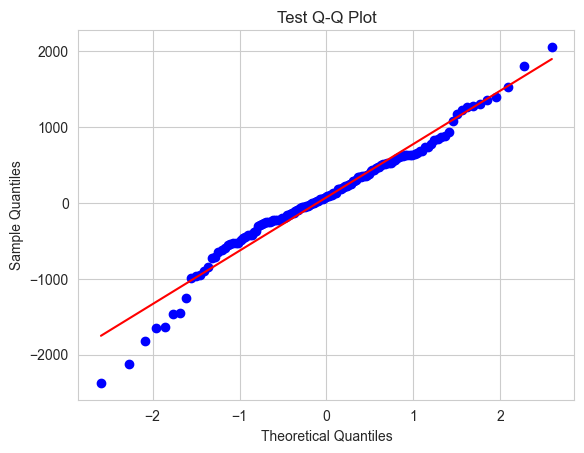

In [17]:
stats.probplot(test_residuals.flatten(), dist="norm", plot=plt)
plt.title("Test Q-Q Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

Residuals of test dataset follows normal distribution

Actual vs. prediction plot

In [18]:
train_tgt_df = pd.DataFrame({'record' : range(len(act_y_train)), 
                             'ground_truth' : act_y_train.flatten(), 
                             'prediction' : act_y_train_pred.flatten(),
                             'kind': ['train'] * len(act_y_train)})

test_tgt_df = pd.DataFrame({'record' : range(len(act_y_test)), 
                            'ground_truth' : act_y_test.flatten(), 
                            'prediction' : act_y_test_pred.flatten(),
                            'kind': ['test'] * len(act_y_test)})

tgt_df = pd.concat([train_tgt_df, test_tgt_df])
tgt_df.shape

(730, 4)

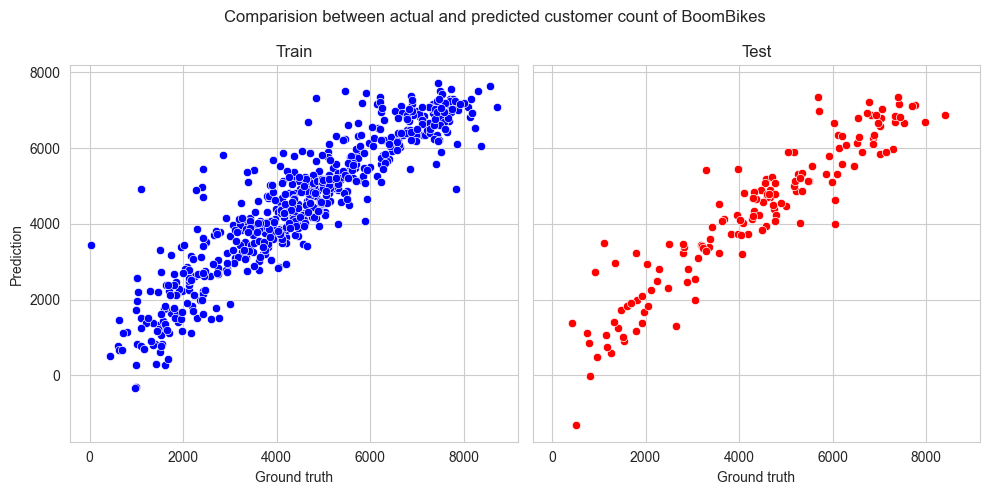

In [19]:
# Plot
fig, axes = plt.subplots(1, 2, figsize = (10, 5), sharex = True, sharey = True)
sns.scatterplot(data = tgt_df[tgt_df['kind'] == 'train'], x = 'ground_truth', y = 'prediction', color = 'blue', ax = axes[0])
sns.scatterplot(data = tgt_df[tgt_df['kind'] == 'test'], x = 'ground_truth', y = 'prediction', color = 'red', ax = axes[1])
for i in [0, 1]:
    axes[i].set_title('Train' if i == 0 else 'Test')
    axes[i].set_xlabel('Ground truth')
    axes[i].set_ylabel('Prediction')

plt.suptitle('Comparision between actual and predicted customer count of BoomBikes')

plt.tight_layout()
plt.show()

Root mean square error between the groud truth and prediction

In [20]:
import math
# train
train_rmse = math.ceil(mean_squared_error(act_y_train, act_y_train_pred, squared=False))

# test
test_rmse = math.ceil(mean_squared_error(act_y_test, act_y_test_pred, squared=False))

#std = math.ceil(np.std(np.concatenate([act_y_train, act_y_test])))
#print(f'Standard deviation of total customer using the BoomBikes services across two years is {std}')
print(f'Prediction error of total customers in the train and test dataset are {train_rmse} and {test_rmse} respectively')

Prediction error of total customers in the train and test dataset are 756 and 710 respectively


Final model expression

In [21]:
maps = {'season_4': 'season_winter',
        'weathersit_3': 'weather_light_rain',
        'season_3': 'season_fall',
        'season_2': 'season_summer'}

In [22]:
expression = 'total customers = '
for idx, variable in enumerate(abs(model.params).sort_values(ascending = False).index):
    coef = model.params[variable]
    sign = '+' if coef > 0 else '-'
    spacer = ''.join([' '] * (idx if idx == 0 else 18))
    variable = maps.get(variable, variable)
    expression += (f'{spacer} {sign} {abs(coef):.4f} {variable}\n')
    
print(expression)

total customers =  - 1.1014 const
                   + 1.0253 yr
                   + 0.8942 season_winter
                   - 0.5439 weathersit
                   - 0.5130 weather_light_rain
                   + 0.5011 season_fall
                   + 0.4907 season_summer
                   + 0.3996 log_temp
                   + 0.3447 mnth_9
                   - 0.3282 mnth_11
                   + 0.2888 weekday_6
                   + 0.2789 mnth_5
                   + 0.2046 workingday
                   + 0.1998 mnth_6
                   - 0.1899 mnth_12
                   + 0.1688 mnth_8
                   + 0.1343 mnth_3
                   - 0.1266 windspeed
                   - 0.1157 hum



Total customer counts are expected to increase in the winter, fall, and summer. Also increase in the mid of the year. When the windspeed and humidity is expected to increase, the customer are willing the opt for the services. Customer are more willing to take the serice in the working day rather than holiday. They might be using for short commuit around the work area. Warmer the temperatures, the customer are willing the take services. Avoid when the weather situtation worsen particularly when it rains.

### END